In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./RNN_scripts")
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from RNN_scripts import dms, ranktwo, clustering
from RNN_scripts.modules import LowRankRNN, train
import seaborn as sns
import pickle

import MARBLE
from MARBLE import utils, geometry, plotting, postprocessing, compare_attractors
from sklearn.decomposition import PCA

/Users/gosztola/opt/anaconda3/envs/MARBLE/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [81]:
matplotlib.rcParams['figure.figsize'] = (6, 5)
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.titlesize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Load trained model

In [3]:
hidden_size = 500
noise_std = 5e-2
alpha = 0.2
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net =  LowRankRNN(2, hidden_size, 1, noise_std, alpha, rank=2)
net.load_state_dict(torch.load(f'./RNN_scripts/dms_rank2_{hidden_size}.pt', map_location='cpu'))
net.svd_reparametrization()

In [4]:
loss_orig, acc_orig = dms.test_dms(net, x_val, y_val, mask_val)
print(acc_orig)
print(loss_orig)

1.0
0.007385289296507835


# Visualising two network populations

In [5]:
n_pops = 2
z, _ = clustering.gmm_fit(net, n_pops, algo='bayes', random_state=2020)  # z will contain labels for the 2 populations

pop 0: slope=-0.01, intercept=-0.04
pop 1: slope=-0.03, intercept=0.06
pop 0: slope=-0.01, intercept=0.02
pop 1: slope=-0.02, intercept=-0.20


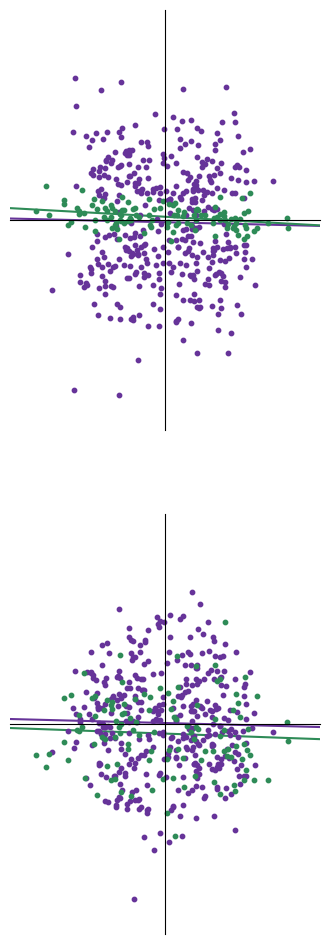

In [6]:
# Visualizing those 2 populations
m = net.m[:,0].detach().numpy()
n = net.n[:,0].detach().numpy() 
wi1 = net.wi[0].detach().numpy()
wi2 = net.wi[1].detach().numpy()

fig, ax = plt.subplots(2, 1, figsize=(4, 12))
colors = ['rebeccapurple', 'seagreen']
fs = 12
clustering.pop_scatter_linreg(n, wi1, z, n_pops, colors=colors, ax=ax[0])
clustering.pop_scatter_linreg(n, wi2, z, n_pops, colors=colors, ax=ax[1])

# Create new network by fitting Gaussian mixture to the connectivity space

In [7]:
net3 = clustering.to_support_net(net, z, scaling=True)

Check that the resampled networks still give the same validation losses

In [8]:
accs2 = []
for _ in range(10):
    net3.resample_basis()
    loss, acc = dms.test_dms(net3, x_val, y_val, mask_val)
    accs2.append(acc)

Train net network for a few epochs

In [ ]:
train(net3, x_train, y_train, mask_train, 20, lr=1e-6, resample=True, keep_best=True, clip_gradient=1)

# Plot phase portraits of the original system for various parameters

In [89]:
stim1_begin, stim1_end, stim2_begin, stim2_end, decision = 25, 50, 200, 225, 275
epochs = [0, stim1_begin, stim1_end, stim2_begin, stim2_end, decision]
gain = [1.0, 0.75, 0.5, 0.0]

input = torch.zeros(4, decision, 2)
input[0, stim1_begin:stim1_end, 0] = gain[0]
input[0, stim2_begin:stim2_end, 0] = gain[0]
input[1, stim1_begin:stim1_end, 0] = gain[1]
input[1, stim2_begin:stim2_end, 0] = gain[1]
input[2, stim1_begin:stim1_end, 0] = gain[2]
input[2, stim2_begin:stim2_end, 0] = gain[2]
input[3, stim1_begin:stim1_end, 0] = gain[3]
input[3, stim2_begin:stim2_end, 0] = gain[3]

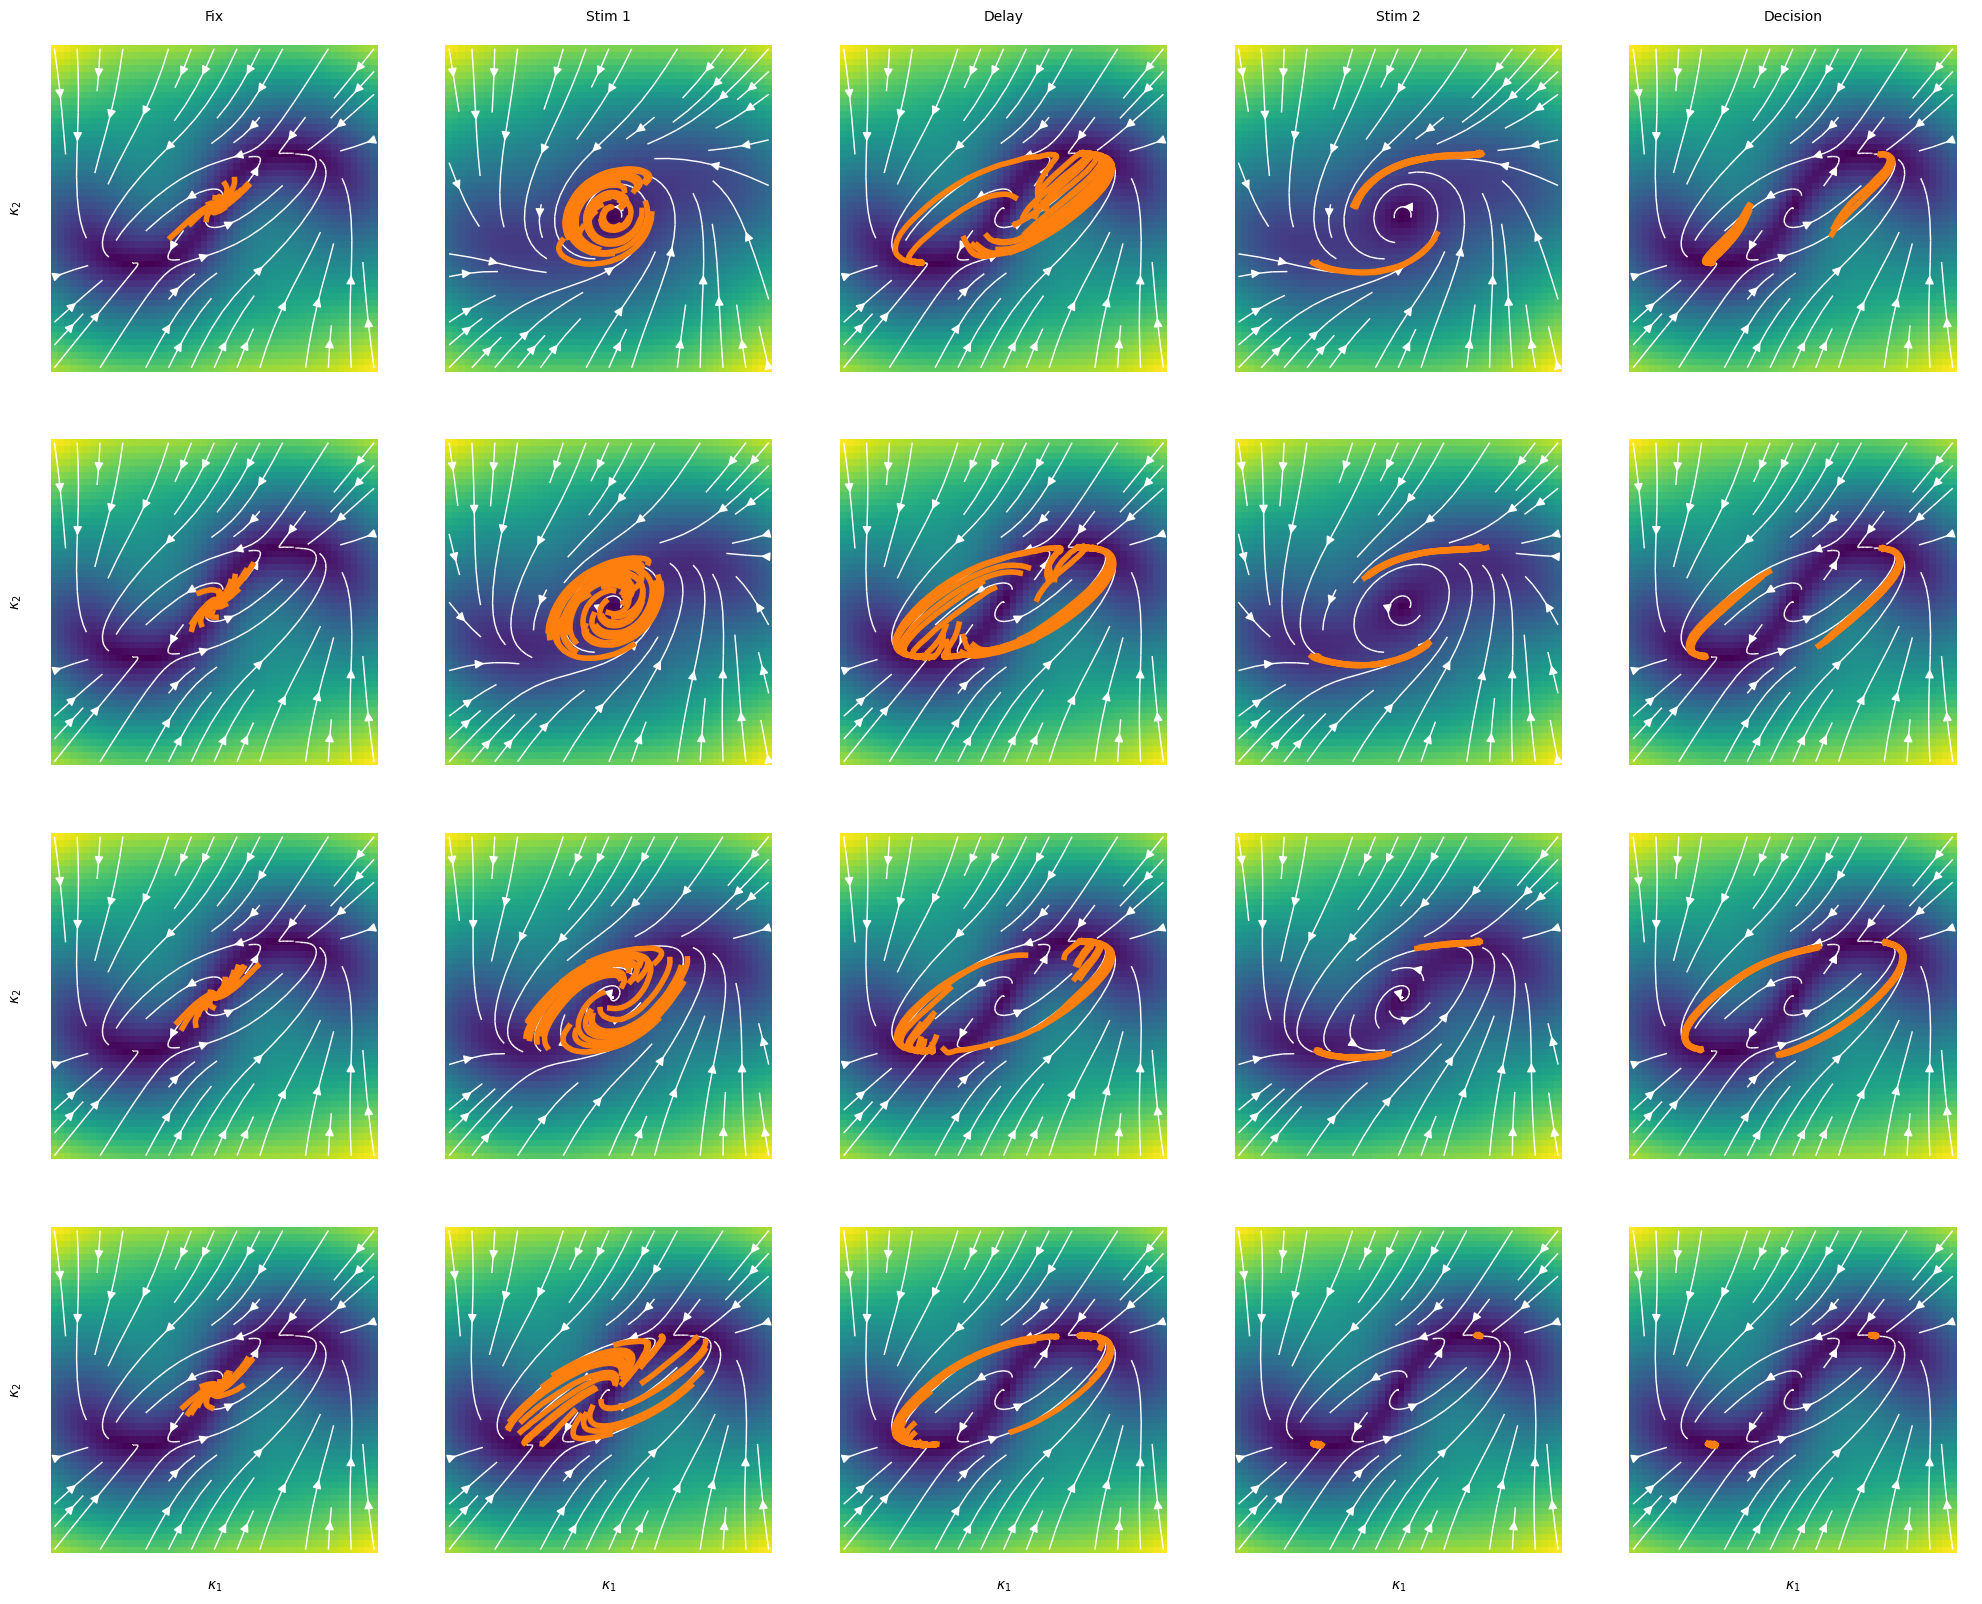

In [119]:
n_traj=20

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
traj = []
for i in range(4):
    
    conds = []
    for k in range(n_traj):
        #net.h0.data = torch.rand(size=net.h0.data.shape) #random ic
        _, traj_ = net(input[i].unsqueeze(0))
        traj_ = traj_.squeeze().detach().numpy()
        traj_epoch = [traj_[e:epochs[j+1]] for j, e in enumerate(epochs[:-1])]
        conds.append(traj_epoch)
        
    traj.append(conds)
    
    for j, e in enumerate(epochs[:-1]):
        dms.plot_field(net, input[i, e], ax[i][j], sizes=1.3)
        epoch = [c[j] for c in conds]
        dms.plot_trajectories(net, epoch, ax[i][j], c='C1', n_traj=len(epoch))
        #if j>0:
        #    epoch = [c[j-1] for c in conds]
        #    dms.plot_trajectories(net, epoch, ax[i][j], c='C0', n_traj=len(epoch))

ax[0][0].set_title('Fix')
ax[0][1].set_title('Stim 1')
ax[0][2].set_title('Delay')
ax[0][3].set_title('Stim 2')
ax[0][4].set_title('Decision')

for i in range(4):
    ax[i][0].set_ylabel('$\kappa_2$')
for i in range(5):
    ax[3][i].set_xlabel('$\kappa_1$')
    
fig.subplots_adjust(hspace=.1, wspace=.1)
# plt.savefig('figures/si_dms_epochs.pdf')

# Plot phase portraits of the resampled system for various parameters

In [ ]:
n_traj=2

fig, ax = plt.subplots(4, 5, figsize=(25, 20))
traj = []
for i in range(4):
    
    conds = []
    for k in range(n_traj):
        #net.h0.data = torch.rand(size=net.h0.data.shape) #random ic
        _, traj_ = net3(input[i].unsqueeze(0))
        traj_ = traj_.squeeze().detach().numpy()
        traj_epoch = [traj_[e:epochs[j+1]] for j, e in enumerate(epochs[:-1])]
        conds.append(traj_epoch)
        
    traj.append(conds)
    
    for j, e in enumerate(epochs[:-1]):
        dms.plot_field(net3, input[i, e], ax[i][j], sizes=1.3)
        epoch = [c[j] for c in conds]
        dms.plot_trajectories(net3, epoch, ax[i][j], c='C1', n_traj=len(epoch))
        if j>0:
            epoch = [c[j-1] for c in conds]
            dms.plot_trajectories(net3, epoch, ax[i][j], c='C0', n_traj=len(epoch))

ax[0][0].set_title('Fix')
ax[0][1].set_title('Stim 1')
ax[0][2].set_title('Delay')
ax[0][3].set_title('Stim 2')
ax[0][4].set_title('Decision')

for i in range(4):
    ax[i][0].set_ylabel('$\kappa_2$')
for i in range(5):
    ax[3][i].set_xlabel('$\kappa_1$')
    
fig.subplots_adjust(hspace=.1, wspace=.1)

In [ ]:
pickle.dump(traj, open('./outputs/RNN_data.pkl','wb'))

# Concatenate data and create dataset

In [151]:
n_neighb = 15
pca_dim = 3

n_conds = len(gain)
n_epochs = len(epochs)-1
pos, vel = [], []
for i in range(n_conds): #conditions
    
    #fit PCA to all data
    pos_, vel_ = [], []
    for k in range(n_epochs): 
        for j in range(n_traj): #trajectorie
            pos_.append(traj[i][j][k])
            
    manifold = PCA(n_components=pca_dim).fit(np.vstack(pos_))
    
    #aggregate data under baseline condition (no input)
    pos_, vel_ = [], []
    for k in [0, 2, 4]:
        for j in range(n_traj): #trajectories
            pos_proj = manifold.transform(traj[i][j][k])
            pos_.append(pos_proj[:-1]) #stack trajectories
            vel_.append(np.diff(pos_proj, axis=0)) #compute differences
                        
    pos_, vel_ = np.vstack(pos_), np.vstack(vel_) #stack trajectories
    pos.append(pos_)
    vel.append(vel_)
        
    #aggregate data under stimulated condition
    pos_, vel_ = [], []
    for k in [1, 3]:        
        for j in range(n_traj): #trajectories
            pos_proj = manifold.transform(traj[i][j][k])
            pos_.append(pos_proj[:-1])
            vel_.append(np.diff(pos_proj, axis=0))
                
    pos_, vel_ = np.vstack(pos_), np.vstack(vel_) #stack trajectories
    pos.append(pos_)
    vel.append(vel_)

data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=n_neighb, stop_crit=0.01)

---- Embedding dimension: 3
---- Signal dimension: 3


Computing gauges...: 100%|████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.23it/s]



Fraction of variance explained:  tensor([0.5548, 0.8996, 1.0000])

---- Manifold dimension: 3

Manifold dimension can decrease with more data. Try smaller values of stop_crit                 before settling on a value


Embedding dimension = manifold dimension, so manifold computations are disabled!


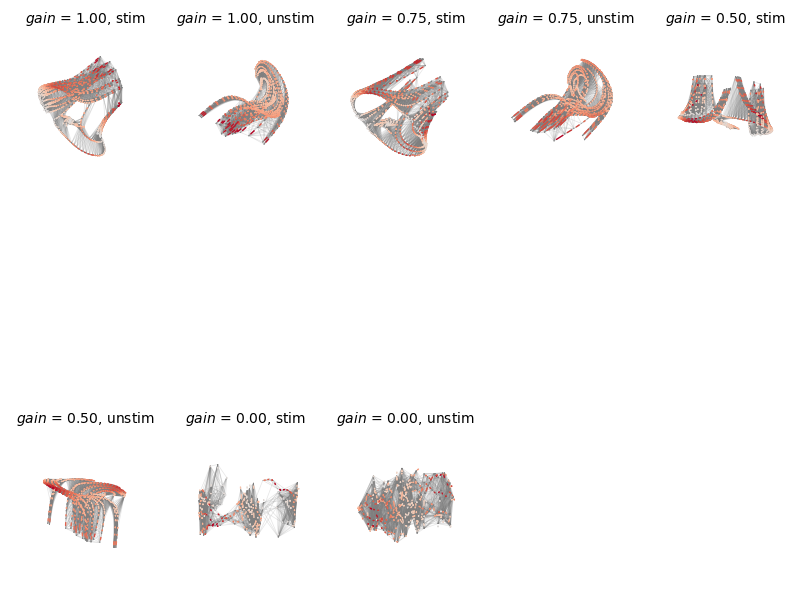

In [149]:
titles = [r'$gain$ = {:0.2f}, {}'.format(g, s) for g in gain for s in ['stim', 'unstim']]

plotting.fields(data, col=5, alpha=0.2, width=0.01, scale=10, titles=titles)
plt.show()

In [152]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

par = {'epochs': 100, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'inner_product_features': True,
      }

model = MARBLE.net(data, **par)
model.run_training(data)


---- Settings: 

epochs : 100
order : 2
hidden_channels : 16
out_channels : 3
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
autoencoder : False
diffusion : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  394

---- Training network ...

Epoch: 1, Training loss: 1.3837, Validation loss: 1.3817, lr: 0.0100 *
Epoch: 2, Training loss: 1.3789, Validation loss: 1.3748, lr: 0.0100 *
Epoch: 3, Training loss: 1.3681, Validation loss: 1.3537, lr: 0.0100 *
Epoch: 4, Training loss: 1.3210, Validation loss: 1.2519, lr: 0.0100 *
Epoch: 5, Training loss: 1.2212, Validation loss: 1.1691, lr: 0.0100 *
Epoch: 6, Training loss: 1.1778, Validation loss: 1.1193, lr: 0.0100 *
Epoch: 7, Training loss: 1.1669, Validation loss: 1.1285, lr: 0.0100
Epoch: 8, Training loss: 1.1283, Va

KeyboardInterrupt: 

Performed umap embedding on embedded results.

 No MDS embedding performed. Embedding seems to be               already in 2D.


AssertionError: 

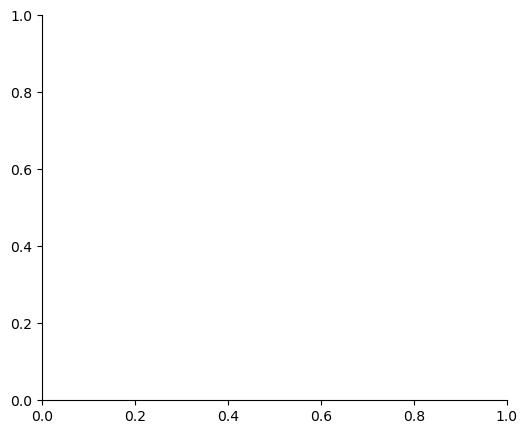

In [144]:
data = model.evaluate(data)
n_clusters=20
data = postprocessing(data, n_clusters=n_clusters)

emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
labels = [g for g in gain for i in range(2)]
plotting.embedding(emb_MDS, labels, s=30, alpha=1)

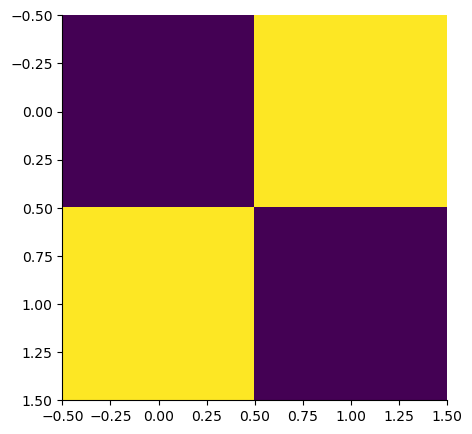

In [145]:
plt.imshow(data.dist)

<AxesSubplot:>

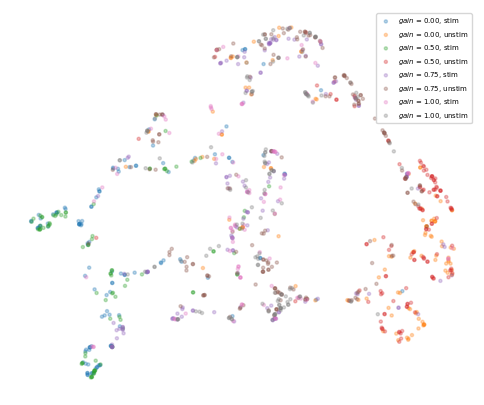

In [80]:
plotting.embedding(data.emb_2d, data.y.numpy(), titles=titles)